## Exercise 1

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

# Parameters
fc = 20  # Hz
wc = 2 * np.pi * fc  # rad/s
fs = 1000  # Hz
dt = 1 / fs  # Sampling time

# Analog transfer function H(s) = 1 / (s + wc)
num = [wc]
den = [1, wc]
system = (num, den)

# Frequency response grid
w_digital, _ = sg.freqz([1], [1], fs=fs)  # Just to get frequency grid

# 1. Forward Euler
# s ≈ (z - 1) / T
sys_fwd = sg.cont2discrete(system, dt, method='forward_diff')

# 2. Backward Euler
# s ≈ (1 - z^-1) / T
sys_bwd = sg.cont2discrete(system, dt, method='backward_diff')

# 3. Impulse Invariance
sys_imp = sg.cont2discrete(system, dt, method='impulse')

# 4. Bilinear Transform (Tustin)
sys_bilinear = sg.cont2discrete(system, dt, method='bilinear')


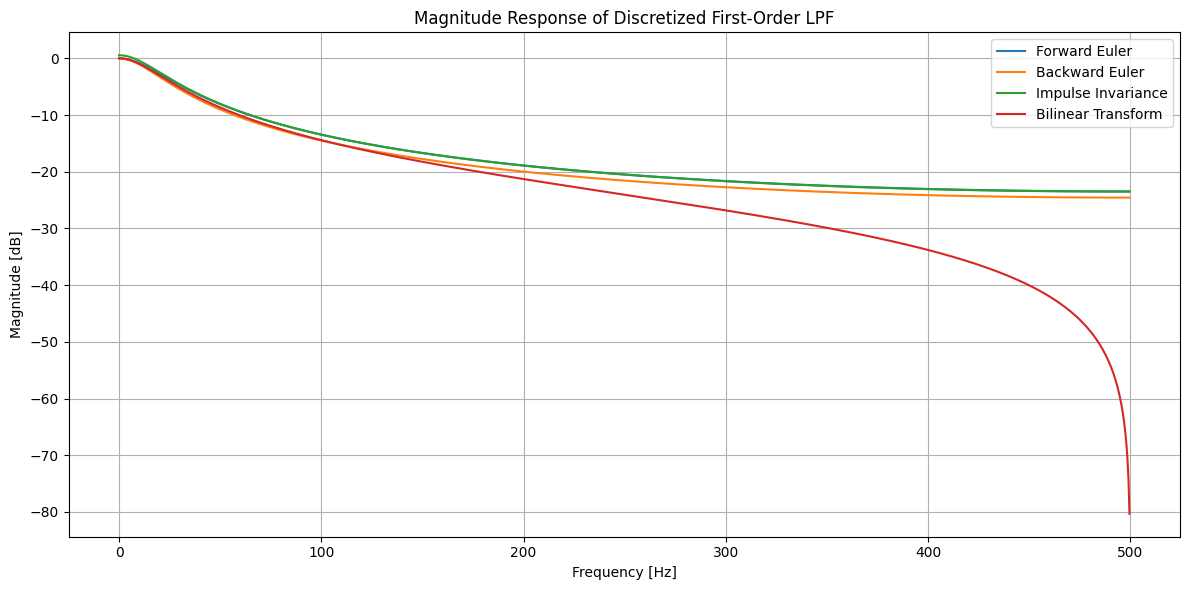

In [54]:
plt.figure(figsize=(12, 6))

methods = {
    'Forward Euler': sys_fwd,
    'Backward Euler': sys_bwd,
    'Impulse Invariance': sys_imp,
    'Bilinear Transform': sys_bilinear,
}

for label, sys_d in methods.items():
    b, a, _ = sys_d
    w, h = sg.freqz(b.squeeze(), a.squeeze(), worN=1024, fs=fs)
    plt.plot(w, 20 * np.log10(np.abs(h)), label=label)

plt.title("Magnitude Response of Discretized First-Order LPF")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()




### **Observations**

| Method              | Stability | Accuracy near \( f_c \) | Notes |
|---------------------|-----------|--------------------------|-------|
| **Forward Euler**   | ❌ May be unstable | Poor | Warps the stable region; not commonly used |
| **Backward Euler**  | ✅ Always stable | Poor frequency warping | Preserves stability, not frequency shape |
| **Impulse Invariance** | ✅ | Good near baseband | Aliases higher frequencies (OK for LPF) |
| **Bilinear Transform** | ✅ | Best overall | Frequency warping but no aliasing |


### **What is the difference in the results?**

- **Forward Euler** distorts the frequency response and can make stable analog filters unstable.
- **Backward Euler** preserves stability but distorts the magnitude response significantly.
- **Impulse Invariance** works well for **low-pass filters** but causes **aliasing**.
- **Bilinear Transform** gives the **most reliable digital approximation** of the analog frequency response with **no aliasing**, though with **frequency warping**.

## Exercise 2

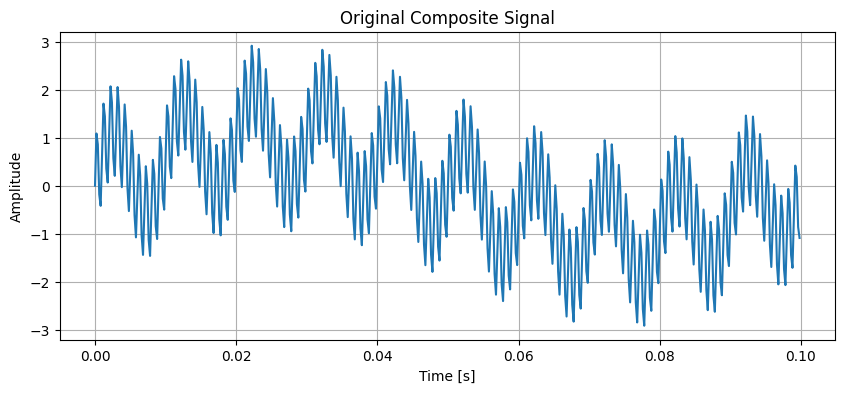

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import buttord, butter, cheb1ord, cheby1, cheb2ord, cheby2, ellipord, ellip
from scipy.signal import freqz, lfilter, tf2zpk

# Sampling and signal
fs = 5000
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*100*t) + np.sin(2*np.pi*1000*t)

plt.figure(figsize=(10, 4))
plt.plot(t[:500], signal[:500])
plt.title("Original Composite Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [56]:
nyq = fs / 2

# Low-pass
fp_lp, fs_lp = 25, 85
wp_lp, ws_lp = fp_lp, fs_lp
ap, as_ = 0.1, 60

# High-pass
fs_hp, fp_hp = 500, 850
ws_hp, wp_hp = fs_hp, fp_hp

# Band-pass
fs1_bp, fp1_bp, fp2_bp, fs2_bp = 50, 80, 500, 700
ws_bp = [fs1_bp, fs2_bp]
wp_bp = [fp1_bp, fp2_bp]


In [57]:
filter_types = {
    "butter": (buttord, butter, {}),
    "cheby1": (cheb1ord, cheby1, {"rp": ap}),
    "cheby2": (cheb2ord, cheby2, {"rs": as_}),
    "ellip":  (ellipord, ellip, {"rp": ap, "rs": as_}),
}

results = {}

for name, (ord_func, design_func, design_kwargs) in filter_types.items():
    results[name] = {}

    # LP
    N_lp, Wn_lp = ord_func(wp_lp, ws_lp, ap, as_, fs=fs)
    results[name]["LP"] = (
        design_func(N=N_lp, Wn=Wn_lp, btype='low', fs=fs, **design_kwargs)[0:2],
        N_lp
    )

    # HP
    N_hp, Wn_hp = ord_func(wp_hp, ws_hp, ap, as_, fs=fs)
    results[name]["HP"] = (
        design_func(N=N_hp, Wn=Wn_hp, btype='high', fs=fs, **design_kwargs)[0:2],
        N_hp
    )

    # BP
    N_bp, Wn_bp = ord_func(wp_bp, ws_bp, ap, as_, fs=fs)
    results[name]["BP"] = (
        design_func(N=N_bp, Wn=Wn_bp, btype='band', fs=fs, **design_kwargs)[0:2],
        N_bp
    )


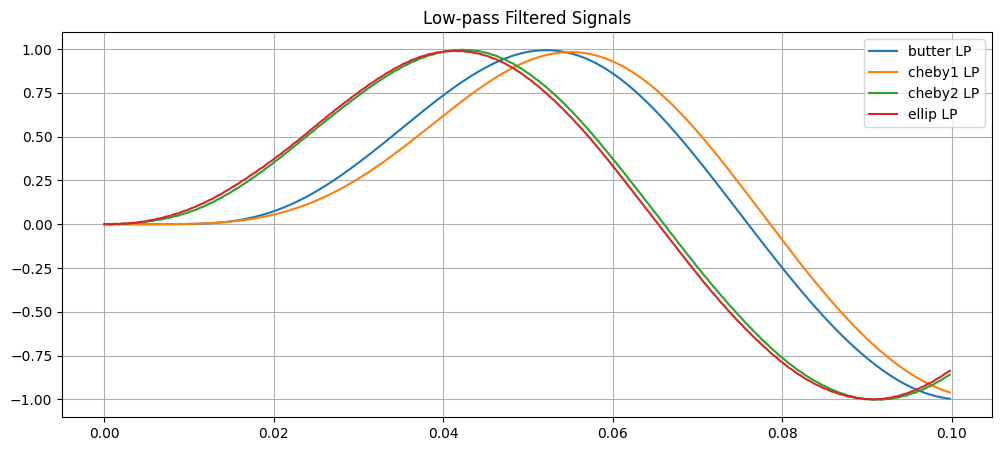

In [58]:
def apply_and_plot(b, a, label):
    y = lfilter(b, a, signal)
    plt.plot(t[:500], y[:500], label=label)

plt.figure(figsize=(12, 5))
for name in results:
    (b, a), _ = results[name]["LP"]
    apply_and_plot(b, a, f"{name} LP")
plt.title("Low-pass Filtered Signals")
plt.legend()
plt.grid()
plt.show()


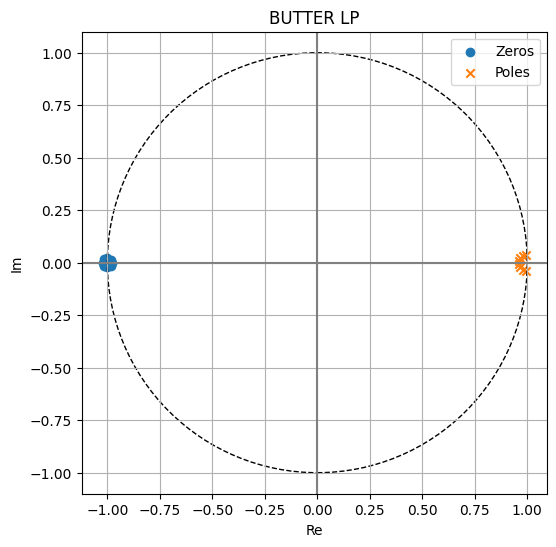

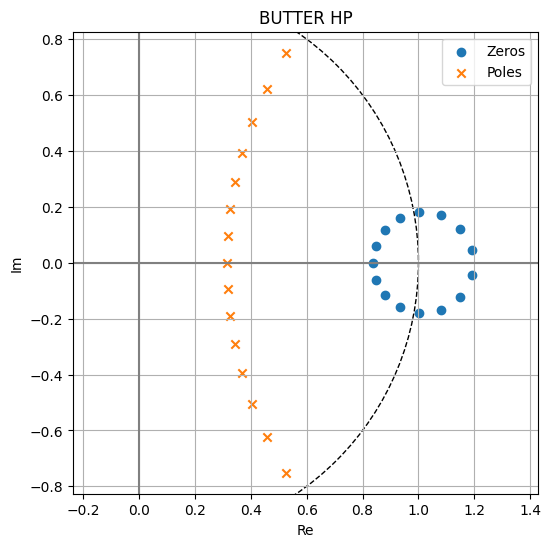

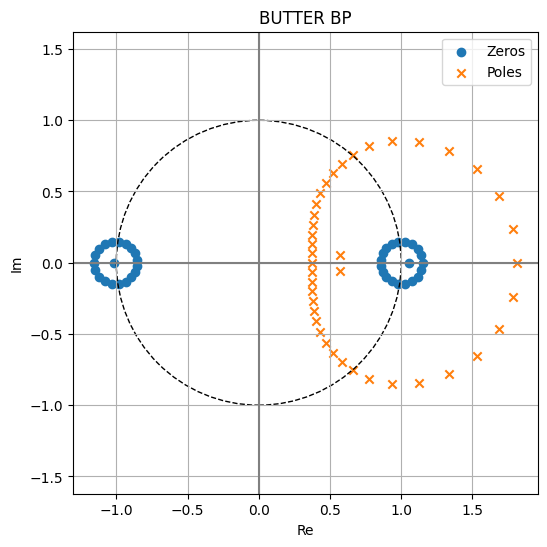

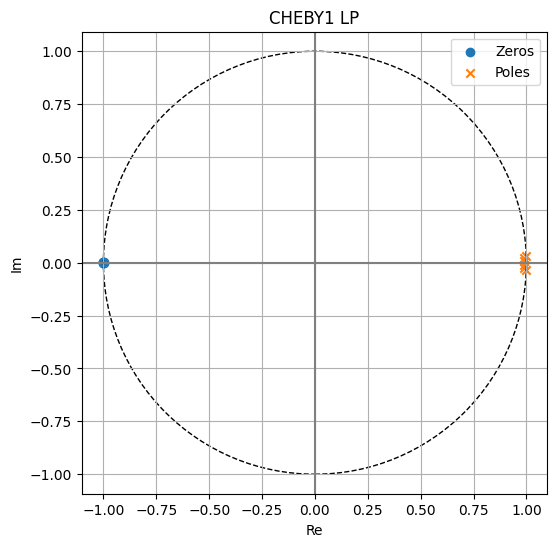

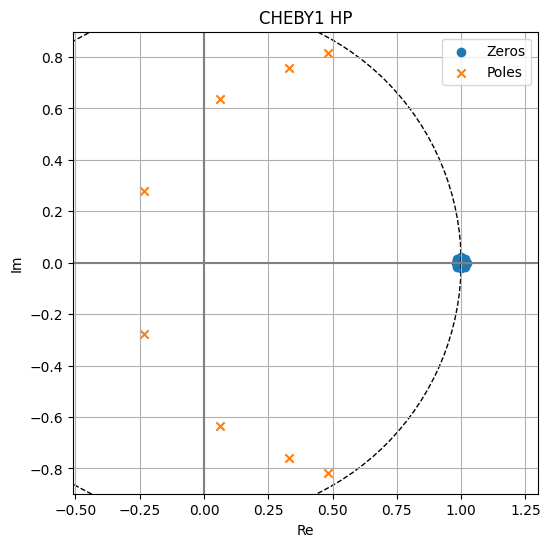

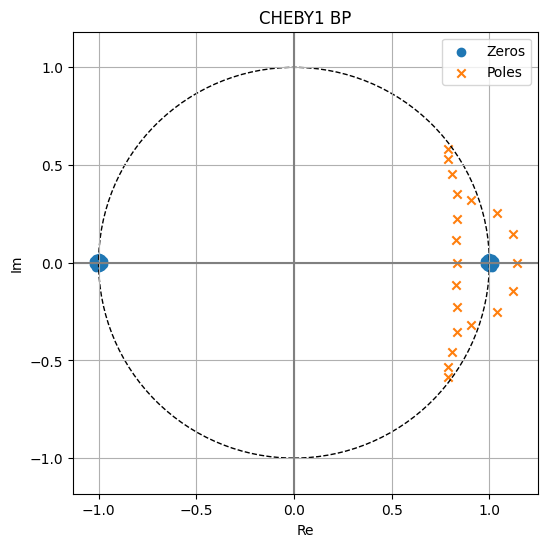

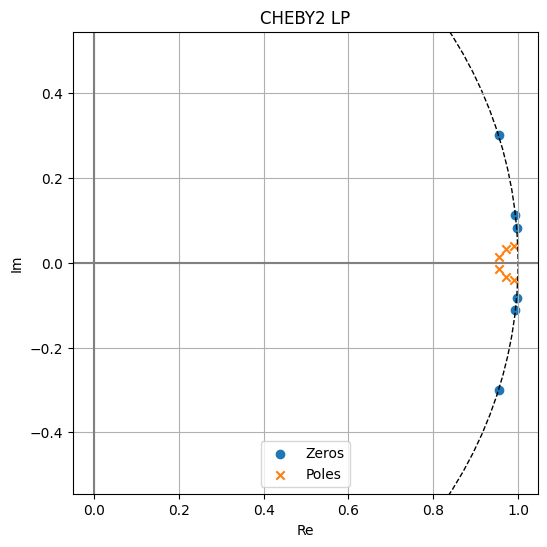

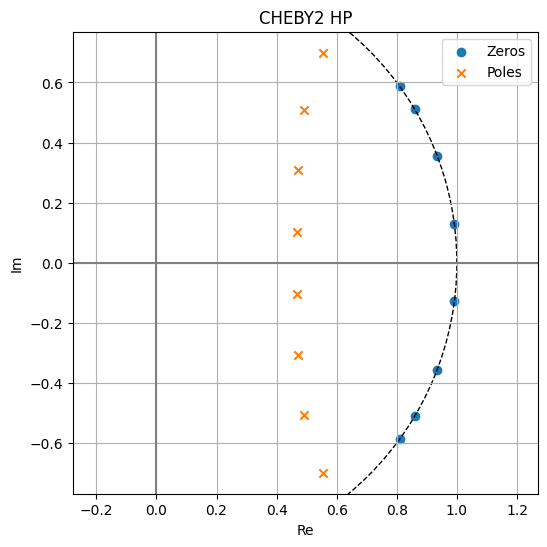

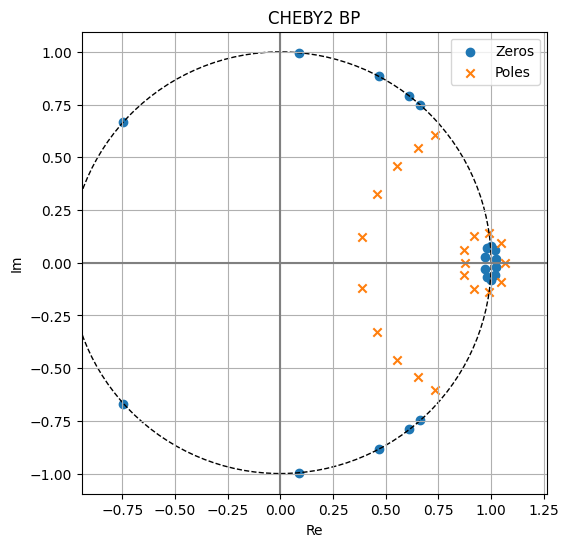

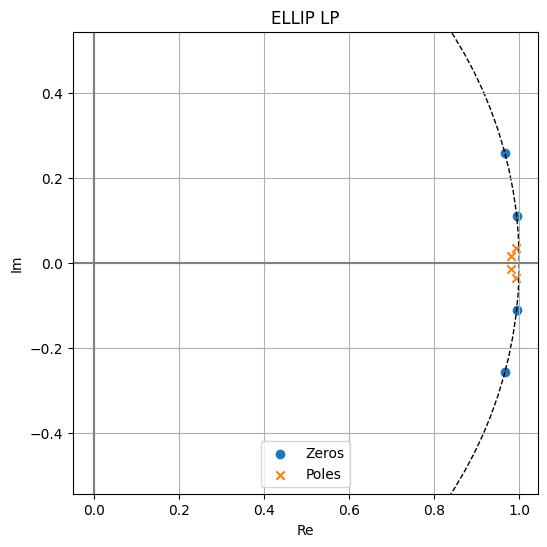

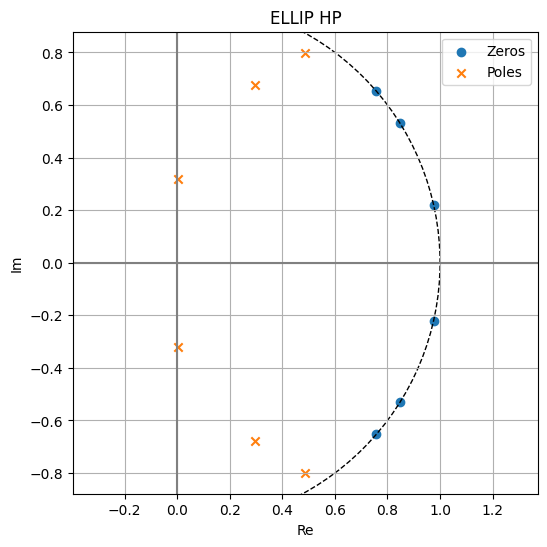

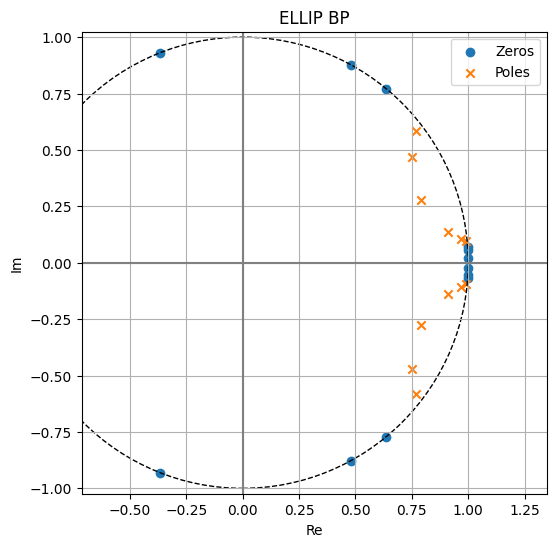

In [59]:
def plot_pz(b, a, title):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.scatter(np.real(z), np.imag(z), marker='o', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', label='Poles')
    unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)
    plt.axhline(0, color='gray')
    plt.axvline(0, color='gray')
    plt.legend()
    plt.grid()
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.axis('equal')
    plt.show()

for name in results:
    for ftype in ["LP", "HP", "BP"]:
        (b, a), _ = results[name][ftype]
        plot_pz(b, a, f"{name.upper()} {ftype}")

In [60]:
print("Filter Orders:")
for name in results:
    N_lp = results[name]['LP'][1]
    N_hp = results[name]['HP'][1]
    N_bp = results[name]['BP'][1]
    print(f"{name.upper()}: LP={N_lp}, HP={N_hp}, BP={N_bp}")


Filter Orders:
BUTTER: LP=8, HP=15, BP=20
CHEBY1: LP=6, HP=8, BP=10
CHEBY2: LP=6, HP=8, BP=10
ELLIP: LP=4, HP=6, BP=6


## Exercise 3

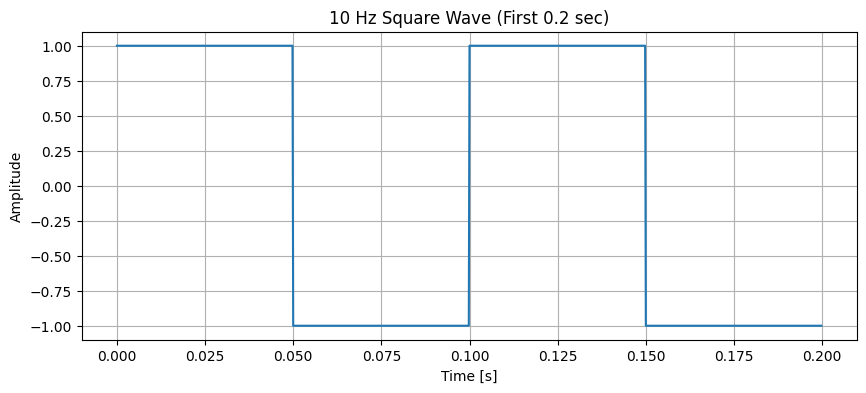

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square, ellip, remez, lfilter, freqz

# Sampling parameters
fs = 5000  # Hz
T = 1      # duration in seconds
t = np.linspace(0, T, int(fs * T), endpoint=False)

# Generate square wave (10 Hz)
square_wave = square(2 * np.pi * 10 * t)

plt.figure(figsize=(10, 4))
plt.plot(t[:1000], square_wave[:1000])
plt.title("10 Hz Square Wave (First 0.2 sec)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [62]:
# Normalize frequencies
fp, fs_stop = 20, 40
wp = fp / (fs / 2)
ws = fs_stop / (fs / 2)
ap, astop = 0.1, 60

# Order and filter design
from scipy.signal import ellipord, ellip

N_ellip, Wn_ellip = ellipord(wp, ws, ap, astop)
b_ellip, a_ellip = ellip(N_ellip, ap, astop, Wn_ellip, btype='low', fs=fs)

# Apply filter
y_ellip = lfilter(b_ellip, a_ellip, square_wave)


In [63]:
# Remez filter
numtaps = 511
bands = [0, 20, 40, fs / 2]
desired = [1, 0]
fir_remez = remez(numtaps, bands, desired, fs=fs)

# Apply filter
y_fir = lfilter(fir_remez, 1.0, square_wave)


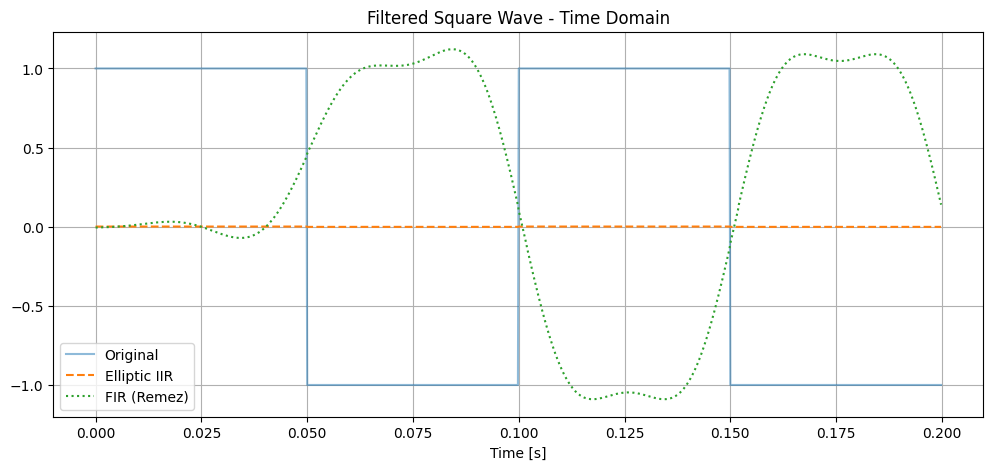

In [64]:
plt.figure(figsize=(12, 5))
plt.plot(t[:1000], square_wave[:1000], label="Original", alpha=0.5)
plt.plot(t[:1000], y_ellip[:1000], label="Elliptic IIR", linestyle='--')
plt.plot(t[:1000], y_fir[:1000], label="FIR (Remez)", linestyle=':')
plt.title("Filtered Square Wave - Time Domain")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()
plt.show()


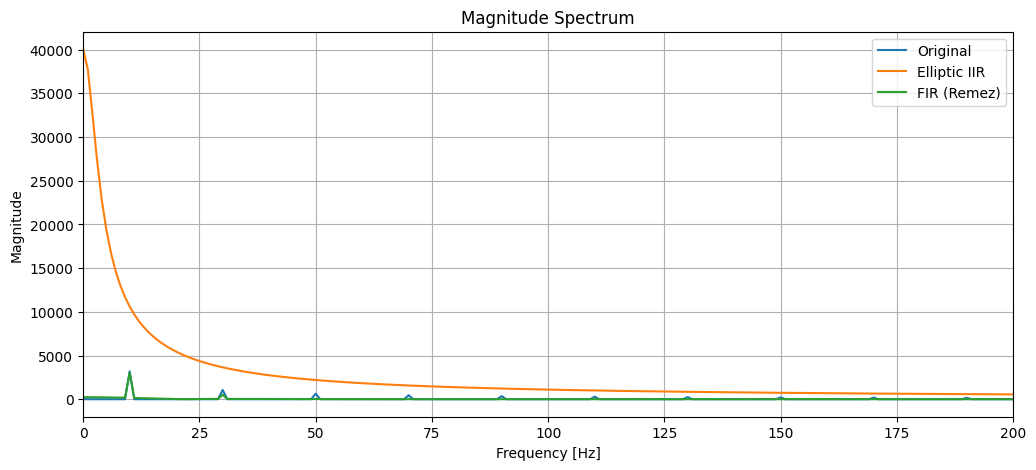

In [65]:
def plot_spectrum(signal, fs, label):
    N = len(signal)
    f = np.fft.rfftfreq(N, d=1/fs)
    mag = np.abs(np.fft.rfft(signal))
    plt.plot(f, mag, label=label)

plt.figure(figsize=(12, 5))
plot_spectrum(square_wave, fs, "Original")
plot_spectrum(y_ellip, fs, "Elliptic IIR")
plot_spectrum(y_fir, fs, "FIR (Remez)")
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 200)
plt.legend()
plt.grid()
plt.show()
